In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Softmax, Multiply
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D

In [8]:
import os                                             # Operational System para manipulação de arquivos.
import cv2                                            # OpenCV para manipulação de imagens.
import random
from sklearn.metrics import confusion_matrix, classification_report    # Scikit-Learn para plotar a matriz de confusão e classification_report
import tensorflow as tf
from tensorflow.keras import layers                   # Módulo de camadas do Keras
from tensorflow.keras import callbacks                # Módulo de callbacks do Keras
from tensorflow.keras import optimizers               # Módulo de otimizadores do Keras
from tensorflow.keras.models import load_model        # Função para carregar um modelo salvo
from tensorflow.keras.models import Sequential        # Classe de modelos sequenciais para construir as redes neurais.
import seaborn as sns
import time

In [9]:
import explainability_algorithms as ea
import occlusion_algorithms as oa
import maps_binarization as mb
import compute_probs as cp

In [4]:
img_loc = ea.get_img_array(img_path = 'DR_test3/NV/ISIC_0025055.jpg',
                       target_size = (224, 224))

In [5]:
densenet_model_loc = tf.keras.models.load_model('EfficientNet+SA.h5')
densenet_model_loc.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

1/1 [==============================] - 0s 59ms/step


Text(0.5, 0, '(d) Guided Grad CAM')

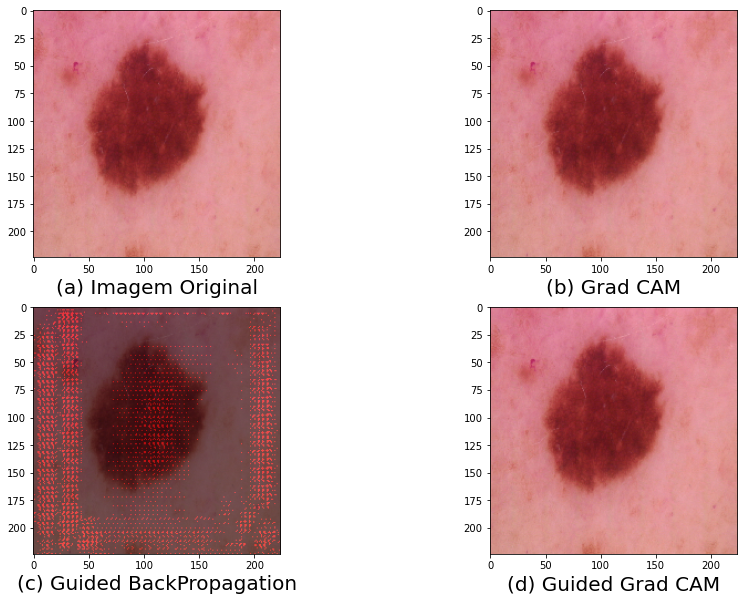

In [8]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))

axs[0,0].imshow(img_loc[0])
axs[0,0].set_xlabel('(a) Imagem Original', color = 'black', size = 20)

img_b = mb.extract_gradcam_otsu(img_array = img_loc,
                                last_conv_layer_name = 'top_conv',
                                copy_model = densenet_model_loc)
img_b = np.dstack((img_b, np.zeros(img_b.shape), np.zeros(img_b.shape)))
axs[0,1].imshow(img_loc[0])
axs[0,1].imshow(img_b, cmap = 'gray', alpha = 0.3)
axs[0,1].set_xlabel('(b) Grad CAM', color = 'black', size = 20)

img_c = mb.extract_backpropagation(img_array = img_loc, model = densenet_model_loc,
                                     copy_model = densenet_model_loc,
                                     last_conv_layer_name = 'top_conv',
                                     type = 'guided_backpropagation')
img_c = np.dstack((img_c, np.zeros(img_c.shape), np.zeros(img_c.shape)))
axs[1,0].imshow(img_loc[0])
axs[1,0].imshow(img_c, cmap = 'gray', alpha = 0.5)
axs[1,0].set_xlabel('(c) Guided BackPropagation', color = 'black', size = 20)


img_e = ea.guided_grad_cam(img_array = img_loc,
                           last_conv_layer_name = 'top_conv',
                           model = densenet_model_loc,
                           copy_model = densenet_model_loc)
img_e = np.dstack((img_e[:, :, 0] + img_e[:, :, 1]+ img_e[:, :, 2],
                   np.zeros(img_e[:, :, 0].shape), np.zeros(img_e[:, :, 0].shape)))

axs[1,1].imshow(img_loc[0])
axs[1,1].imshow(img_e, cmap = 'gray', alpha = 0.8)
axs[1,1].set_xlabel('(d) Guided Grad CAM', color = 'black', size = 20)

## Fazendo o GradCam com o heatmap

In [10]:
model = load_model('EfficientNet+SA.h5')

In [12]:
img_loc = ea.get_img_array(img_path = 'DR_test3/NV/ISIC_0025055.jpg',
                       target_size = (224, 224))
img_loc = img_loc*255

img_loc1 = ea.get_img_array(img_path = 'DR_test3/BCC/ISIC_0026213.jpg',
                       target_size = (224, 224))
img_loc1 = img_loc1*255

img_loc2 = ea.get_img_array(img_path = 'DR_test3/DF/ISIC_0032613.jpg',
                       target_size = (224, 224))
img_loc2 = img_loc2*255

In [13]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Primeiro, criamos um modelo que mapeia a imagem de entrada para as ativações
    # da última camada convolucional, bem como as previsões de saída
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Em seguida, calculamos o gradiente da classe de previsão com maior probabilidade para nossa imagem de entrada
    # em relação às ativações da última camada convolucional
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Este é o gradiente do neurônio de saída (previsão superior ou escolhida)
    # em relação ao mapa de características de saída da última camada convolucional
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Este é um vetor onde cada entrada é a intensidade média do gradiente
    # em um canal específico do mapa de características
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplicamos cada canal no array do mapa de características
    # por "o quão importante é esse canal" em relação à classe de previsão superior
    # e depois somamos todos os canais para obter a ativação de classe do mapa de calor (Grad Cam)
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Para fins de visualização, também normalizaremos o mapa de calor entre 0 e 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [99]:
preds = model.predict(img_loc)
np.argmax(preds)

1/1 [==============================] - 1s 1s/step


5

In [100]:
heatmap = make_gradcam_heatmap(img_loc, model, 'top_conv')

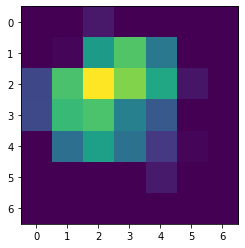

In [101]:
plt.imshow(heatmap)

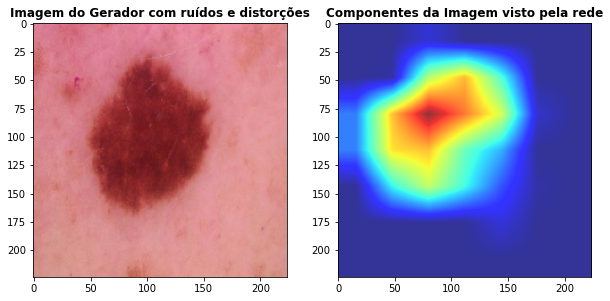

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


#Plotando as imagens:
axs[0].set_title('Imagem do Gerador com ruídos e distorções', fontweight='bold')
axs[0].imshow(img_loc[0]/255)
axs[1].set_title('Componentes da Imagem visto pela rede', fontweight='bold')
axs[1].imshow(cv2.resize(heatmap,(224,224)),cmap='jet',alpha = 0.8)

In [14]:
def overlay_grad_cam_on_image(original_image, grad_cam, alpha=0.7):

    # Convertendo o Grad-CAM para o formato de imagem colorida (três canais)
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)

    # Redimensionando o Grad-CAM para o tamanho da imagem original
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    # Convertendo o Grad-CAM para RGB
    grad_cam_color = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Mesclando a imagem original com o Grad-CAM usando uma combinação ponderada
    overlayed_image = cv2.addWeighted((original_image*255).astype(np.uint8), alpha, grad_cam_color, 1 - alpha, 0)

    return overlayed_image

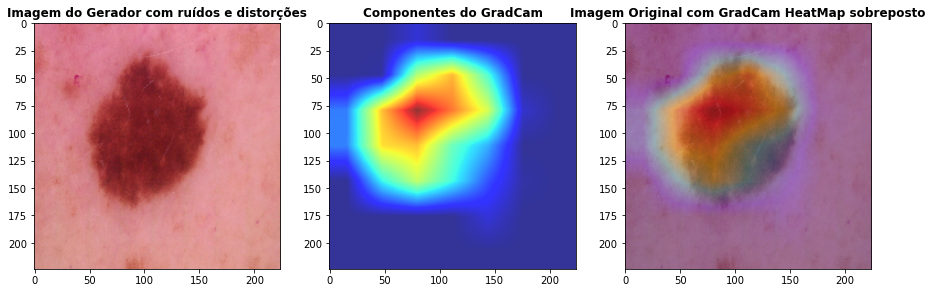

In [116]:
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

img_original = img_loc[0]/255
#Plotando as imagens:
axs[0].set_title('Imagem do Gerador com ruídos e distorções', fontweight='bold')
axs[0].imshow(img_original)
axs[1].set_title('Componentes do GradCam', fontweight='bold')
axs[1].imshow(cv2.resize(heatmap,(img_original.shape[0],img_original.shape[1])),cmap='jet',alpha = 0.8)
axs[2].set_title('Imagem Original com GradCam HeatMap sobreposto', fontweight = 'bold')
axs[2].imshow(overlay_grad_cam_on_image(img_original,cv2.resize(heatmap,(224,224))))

### Aplicando o algoritimo em outras imagens imagens:

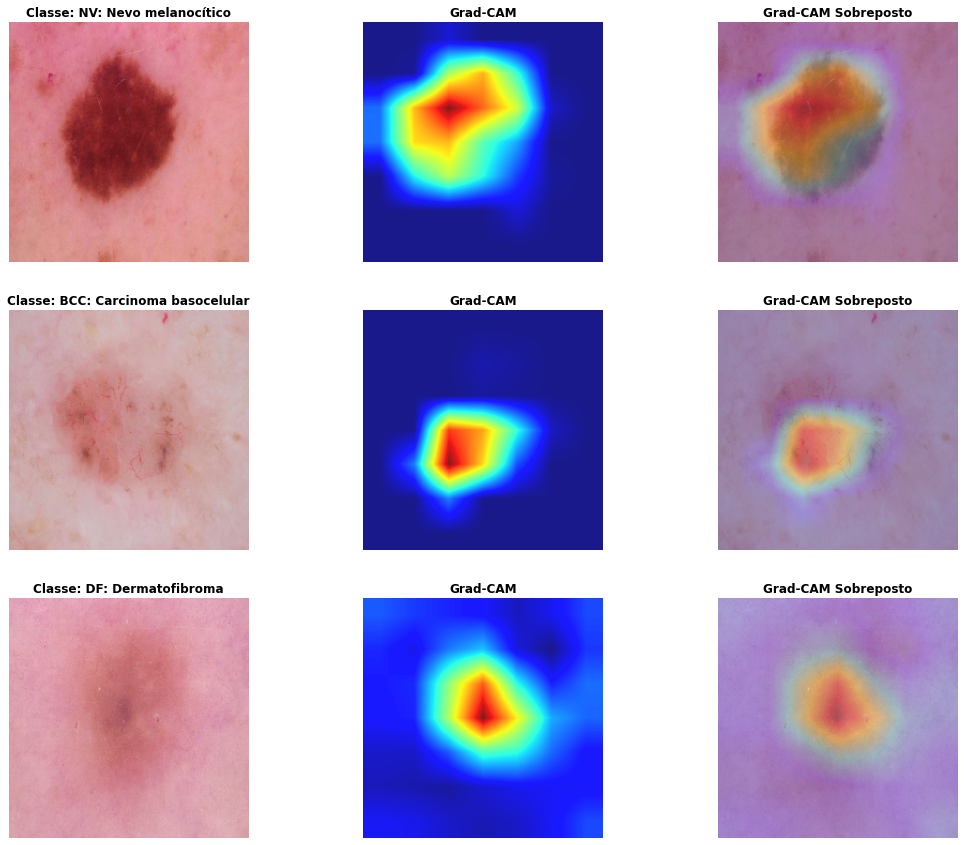

In [37]:
image_paths = ['DR_test3/NV/ISIC_0025055.jpg', 'DR_test3/BCC/ISIC_0026213.jpg', 'DR_test3/DF/ISIC_0027598.jpg']

# Nome das camadas convolucionais que deseja usar para Grad-CAM (ajuste conforme necessário)
last_conv_layer_name = 'top_conv'

# Título das classes (ajuste conforme necessário)
class_names = ['NV: Nevo melanocítico','BCC: Carcinoma basocelular', 'DF: Dermatofibroma']

# Loop sobre as imagens e gere os subplots
fig, axs = plt.subplots(3, 3, figsize=(18, 15))

for i, img_path in enumerate(image_paths):
    img_loc = ea.get_img_array(img_path=img_path, target_size=(224, 224))
    img_loc = img_loc * 255

    heatmap = make_gradcam_heatmap(img_loc, model, last_conv_layer_name)
    overlayed_image = overlay_grad_cam_on_image(img_loc[0] / 255, cv2.resize(heatmap,(224,224)))

    axs[i, 0].set_title(f'Classe: {class_names[i]}', fontweight='bold')
    axs[i, 0].imshow(img_loc[0] / 255)
    axs[i, 0].axis('off')
    
    axs[i, 1].set_title('Grad-CAM', fontweight='bold')
    axs[i, 1].imshow(cv2.resize(heatmap,(224,224)), cmap='jet', alpha=0.9)
    axs[i, 1].axis('off')
    
    axs[i, 2].set_title('Grad-CAM Sobreposto', fontweight='bold')
    axs[i, 2].imshow(overlayed_image, alpha = 0.9)
    axs[i, 2].axis('off')

plt.savefig('subplots_gracam_sobreposto.jpg')
plt.show()
